In [2]:
%matplotlib inline

In [278]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix

### Load and explore data

In [4]:
data = pd.read_csv('scientific_revenue/2017-08-05_MobilityWare_BlackjackFree_campaign_name_IOS_SPEND_.csv')

#### Basic information about the data
* data.head()
* data.shape
* data.info()
* data.columns

In [5]:
data.head()

,Unnamed: 0,t0_geoip_metro_code,time_zone_offset,manufacturer,model,product,device_kind,form_factor_name,total_ram_in_kb,primary_storage_total_in_mb,...,pct_25_up,ppl_per_hh,pct_owner_occupied_hh,assignedIdentity,out,ecosystemAdvertisingId,JOINED_AT_DATE_TIME_LOCAL,SPEND_PROBABILITY,LTV,FIVE_DAY_SPEND
0,1,MC-618,-300,Apple Inc.,iPad,"iPad7,2",MINI,NaN,4071424,488271,...,63.202058,2.934443,61.840101,7b861e7b740db946deb8fb7d31676f929a30b76e,0.0,FE76DDBA-606D-4E29-89ED-BB2C4256EE3F,2017-06-29 06:29:01,0.545285,0.0,0.0
1,2,MC-635,-300,Apple Inc.,iPad,"iPad7,4",MINI,NaN,4098048,488271,...,64.862676,2.711592,59.065396,818a34e1961d8a03a354c784b6cb5a0d79de1385,0.0,1636A406-2DFF-4B80-B395-5F0F40B9518F,2017-06-24 16:02:33,0.543682,0.0,0.0
2,3,MC-641,-300,Apple Inc.,iPad,"iPad7,2",MINI,NaN,4071424,488271,...,63.446502,2.907557,63.861701,3ed2a02c057ccf3b36bee79e27416622280af617,0.0,76812F66-1752-4B6E-95C8-B071FB0A72BF,2017-06-30 16:58:45,0.537402,0.0,0.0
3,4,MC-501,-240,Apple Inc.,iPad,"iPad7,4",MINI,NaN,4098048,488271,...,NaN,NaN,NaN,77a708c9ec4571a10372084eb01a056f8fc0608d,0.0,DAF38BA2-7D79-450C-9D92-0B9B312CC652,2017-06-22 09:07:03,0.522588,0.0,0.0
4,5,MC-501,-240,Apple Inc.,iPad,"iPad7,4",MINI,NaN,4098048,488271,...,NaN,NaN,NaN,43a9511395b6374ad22463ade5e0d9da564c1f2e,0.0,219CA81A-73D6-446C-B2AC-24B2B2983613,2017-06-26 01:43:55,0.509655,0.0,0.0


In [6]:
data.shape

(5000, 114)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 114 entries, Unnamed: 0 to FIVE_DAY_SPEND
dtypes: bool(1), float64(69), int64(14), object(30)
memory usage: 4.3+ MB


In [8]:
for c in data.columns:
    print c

Unnamed: 0
t0_geoip_metro_code
time_zone_offset
manufacturer
model
product
device_kind
form_factor_name
total_ram_in_kb
primary_storage_total_in_mb
t0_primary_storage_free_in_mb
secondary_storage_total_in_mb
t0_secondary_storage_free_in_mb
screen_height_pixels
screen_width_pixels
total_pixels
x_dpi
y_dpi
density_dpi
brand
time_zone_id
t0_os_version
t0_sdk_version
t0_connectivity
android_device
android_board
android_display
android_screen_size
carrier_name
mvno_name
t0_battery_level
t0_charging
t0_geoip_country
t0_geoip_state
billing_country
sim_country
physical_country
locale_country
estimated_country
t0_churn_probability
t0_spend_probability
joined_at_local_hour
joined_at_local_time
joined_at_local_day_of_week
locale_language
in_vehicle
on_bicycle
on_foot
is_running
is_still
is_tilting
is_unknown
is_walking
country_affluence_score_name
treatment
list_price_usd
current_price_usd
release_date
has_rear_camera
has_front_camera
back_camera_mp
front_camera_mp
cpu_model
cpu_number_of_cores
c

#### Split into training and test sets
* train_test_split()
* StratifiedShuffleSplit() -- usually use a feature with high correlation with the target

In [80]:
# Use list_price_usd for stratified sampling. Need to replace NaN with some value.
y_column = data['list_price_usd'].fillna(0.0)

In [81]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for training_index, test_index in split.split(data, y_column):
    training = data.loc[training_index]
    test = data.loc[test_index]

#### Look at individual features in the training data
* training.corr()
* training.hist()
* scatter_matrix()
* training.value_counts()
* normalized_mutual_info_score()

In [124]:
# Get correlation between numerical features and predicting target.
spend_correlation = training.corr()['SPEND_PROBABILITY']
corr_df = pd.DataFrame(spend_correlation)
numerical_features = training[corr_df.index] # numerical_features = training.select_dtypes(include=['float64'])
categorical_features = training.drop(corr_df.index, axis=1)

In [172]:
# Get high-correlation features.
high_corr = corr_df[(np.abs(corr_df['SPEND_PROBABILITY']) > 0.2) & (np.abs(corr_df['SPEND_PROBABILITY']) < 0.8)]
high_corr_features = numerical_features[high_corr.index]

In [126]:
high_corr['SPEND_PROBABILITY'].sort_values()

current_price_usd                0.208119
display_width                    0.221311
total_ram_in_kb                  0.263667
t0_primary_storage_free_in_mb    0.644055
primary_storage_total_in_mb      0.734880
Name: SPEND_PROBABILITY, dtype: float64

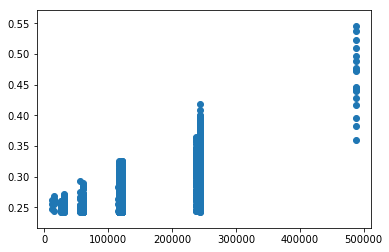

In [193]:
plt.scatter(numerical_features['primary_storage_total_in_mb'], training['SPEND_PROBABILITY'])

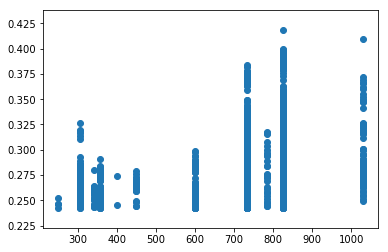

In [196]:
plt.scatter(numerical_features['current_price_usd'], training['SPEND_PROBABILITY'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1230bbd10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1249496d0>]], dtype=object)

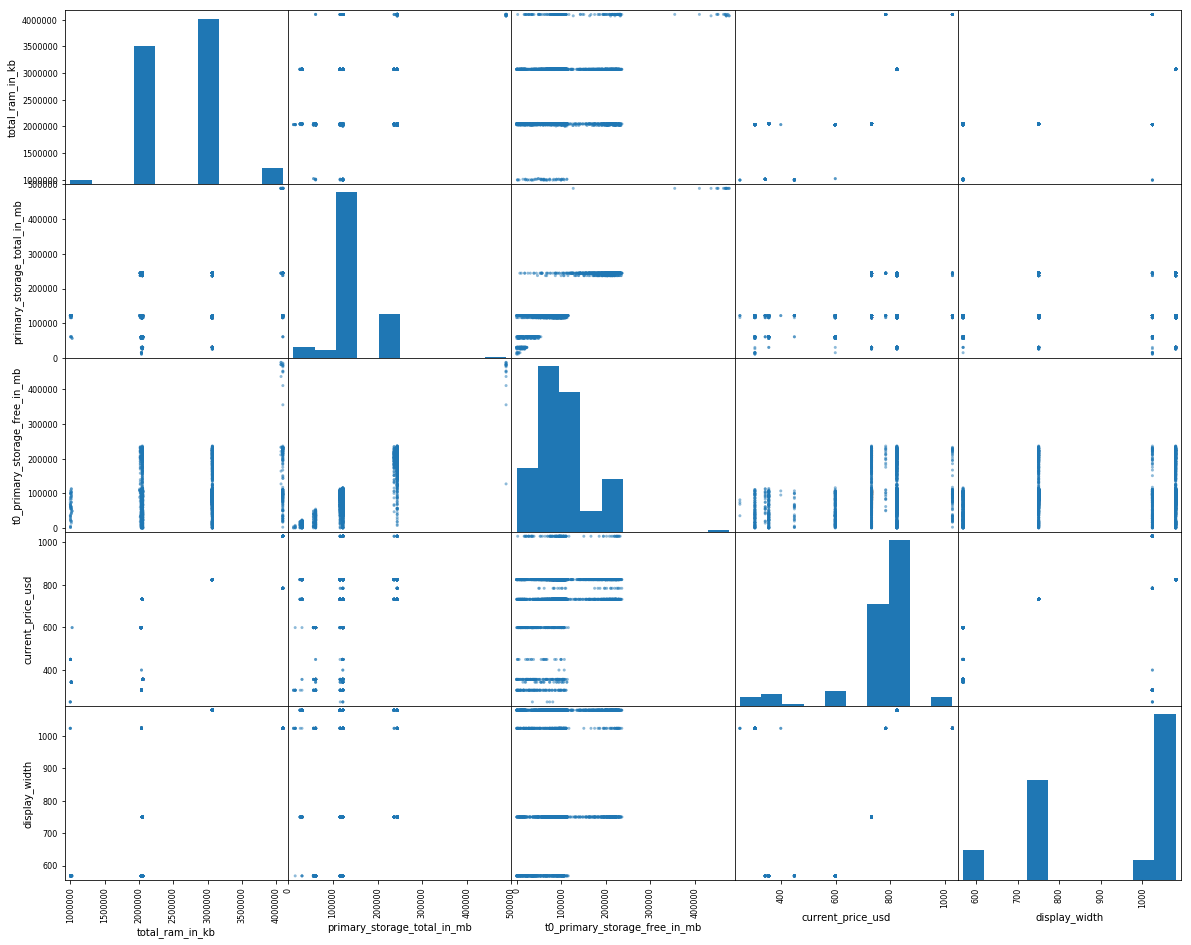

In [127]:
# Check correlation among these features.
scatter_matrix(high_corr_features, figsize=(20, 16))

In [128]:
high_corr_features.corr()

,total_ram_in_kb,primary_storage_total_in_mb,t0_primary_storage_free_in_mb,current_price_usd,display_width
total_ram_in_kb,1.000000,0.208125,0.208235,0.729735,0.856664
primary_storage_total_in_mb,0.208125,1.000000,0.888606,0.238871,0.147542
t0_primary_storage_free_in_mb,0.208235,0.888606,1.000000,0.261001,0.147758
current_price_usd,0.729735,0.238871,0.261001,1.000000,0.608481
display_width,0.856664,0.147542,0.147758,0.608481,1.000000


In [182]:
# Get mutual information between categorical features and predicting target. 
mi = []
cardinality = []
for c in categorical_features.columns:
    mi = mi + [normalized_mutual_info_score(training['SPEND_PROBABILITY'], categorical_features[c])]
    cardinality = cardinality + [len(categorical_features[c].value_counts())]
mi_df = pd.DataFrame(categorical_features.columns, columns = ['feature'])
mi_df['mutual_information'] = mi
mi_df['cardinality'] = cardinality

In [189]:
# Get high-MI features.
high_mi = mi_df[(mi_df['mutual_information'] >= 0.4) & (mi_df['mutual_information'] < 0.9)]
high_mi

,feature,mutual_information,cardinality
0,t0_geoip_metro_code,0.730698,165
3,product,0.490509,21
5,form_factor_name,0.415181,3
11,carrier_name,0.424463,69
13,t0_geoip_state,0.615648,100
18,joined_at_local_time,0.447946,5
24,has_rear_camera,0.655385,1
25,has_front_camera,0.655385,1


In [190]:
# Check mutual information among these features.
normalized_mutual_info_score(categorical_features['t0_geoip_metro_code'], categorical_features['t0_geoip_state'])

0.8368987421684424

In [191]:
normalized_mutual_info_score(categorical_features['has_front_camera'], categorical_features['has_rear_camera'])

1.0

In [204]:
# Drop redundant features
high_mi = high_mi[high_mi['feature'] != 'has_rear_camera']

### Preprocessing data
* Remove outliers
* Deal with missing values
* Feature scaling
* Convert categorical features into binary features
* Remove binary features with too few positives

In [199]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [281]:
# Process numerical features
imputer = Imputer(strategy='median')
scaler = StandardScaler()
num_prepared = pd.DataFrame(scaler.fit_transform(imputer.fit_transform(training[high_corr_features.columns])),
                            columns = high_corr_features.columns, index=training.index)

In [259]:
# Process categorical features
cat_encoded = pd.get_dummies(training[high_mi['feature'].values])
cat_summary = pd.DataFrame(cat_encoded.sum(), columns = ['count'])
cat_summary = cat_summary[cat_summary['count'] >= 20]
cat_prepared = cat_encoded[cat_summary.index]

In [277]:
data_prepared = pd.concat([num_prepared, cat_prepared], axis=1)